In [1]:
import sys
sys.path.append('./code')
from importlib import reload

In [35]:
from make_figure4 import *
from config import row_colors, columns_to_names, row_colors_dict

SyntaxError: invalid syntax (config.py, line 69)

In [3]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [4]:
from initialize import *
import cooler 

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')


(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)

# (_, _, region_to_inds_50kb, all_region_to_ind_50kb, 
#     inds_to_region_50kb, all_ind_to_region_50kb,
#     chrom_to_start_50kb, chrom_to_end_50kb) = initialize_helper_vars(treg_50kb)

In [5]:
from make_figure4 import *

padding_size = 30
def fetch_mat(cool):
    if 'chr' not in chrom1:
        mat = cool.matrix().fetch('chr' + chrom1, 'chr' + chrom2)
    else:
        mat = cool.matrix().fetch(chrom1, chrom2)
    oe_mat = np.exp(normalize_raw_intra(mat, nan_to_zero=False, balance=True))
    padded_mat = np.pad(oe_mat, pad_width=padding_size, mode='constant', constant_values=np.nan)
    return padded_mat
    
def append_mats(cool, name, rows, cols, mat_dict):
    padded_mat = fetch_mat(cool)
    for row, col in zip(rows, cols):
        row, col = row+padding_size, col+padding_size
        submat = padded_mat[row-30:row+30, col-30:col+30]
        # print(submat.shape, padded_mat.shape, row, col)
        # assert submat.shape == (31, 31), (submat.shape, row, col, padded_mat.shape)
        mat_dict[name].append(submat)

#### Pileup Of interchromosomal hubs

In [7]:
from initialize import *
import cooler 

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')


(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)

# (_, _, region_to_inds_50kb, all_region_to_ind_50kb, 
#     inds_to_region_50kb, all_ind_to_region_50kb,
#     chrom_to_start_50kb, chrom_to_end_50kb) = initialize_helper_vars(treg_50kb)

In [9]:
import make_figure4
reload(make_figure4)
from make_figure4 import *
import pickle

self = pickle.load(open('./for_s1/self_object', 'rb'))

goodinds = pickle.load(open('./for_snipping/goodinds', 'rb'))
merged_clustdict = pickle.load(open('./for_snipping/merged_clustdict', 'rb'))
merged_clustdict = pickle.load(open('./for_snipping/merged_clustdict', 'rb'))
merged_inds_to_subset = pickle.load(open('./for_snipping/merged_inds_to_subset', 'rb'))


cooldict_50kb = pickle.load(open('./for_snipping/cooldict_50kb', 'rb'))
ind_to_gene = pickle.load(open('./for_snipping/ind_to_gene', 'rb'))
all_ind_to_region = pickle.load(open('./for_snipping/all_ind_to_region', 'rb'))

my_treg_comp = pickle.load(open('./for_snipping/my_treg_comp', 'rb'))



In [21]:
gene_to_ind = pickle.load(open('gene_to_ind.p', 'rb'))

df = pd.DataFrame([self.goodinds, self.merged_clustdict['all']]).T
df = df[df[1].isin([0, 4, 18])]
df.columns = ['ind', 'cluster']
df['chrom'] = [all_ind_to_region[x][0] for x in df['ind'].values]
df['chrom'] = 'chr' + df['chrom']


In [28]:
%autoreload 2
from hub_pileup import *
from compute_differential_hic_hub import *
from collections import defaultdict
from make_figure4 import *
import itertools
import cooler

cooldict_25kb = {
    'Treg' : cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/TReg.mcool::/resolutions/25000'),
    'Tcon' : cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/TCon.mcool::/resolutions/25000'),

}

padding_size = 50

inter_hub_all_mat_dict, inter_hub_all_metadata = pileup_bins_with_hub(df, cooldict_25kb, 
                                                              {'chr' + x : y for x, y in chrom_to_start.items()}, 
                                                              None, 
                                                              None, 
                                                              padding_size=padding_size, 
                                                              fetch_oe=True,
                                                              resolution_out = 25_000,
                                                              skip_metadomains =True
                                                                     )

Done with chr10
Done with chr11
Done with chr11
Done with chr12
Done with chr12
Done with chr12
Done with chr13
Done with chr13
Done with chr13
Done with chr13
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr15
Done with chr15
Done with chr15
Done with chr15
Done with chr15
Done with chr15
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr2
Done with chr2
Done with chr2
Done with chr2
Done with chr2
Done with chr2
Done with chr2
Done with chr2


Treg


/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:75: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:76: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hub_pileup.py:407: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels([-cutoff, "Anchor1", cutoff])
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hub_pileup.py:445: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels([-cutoff, "Anchor1", cutoff])


Tcon


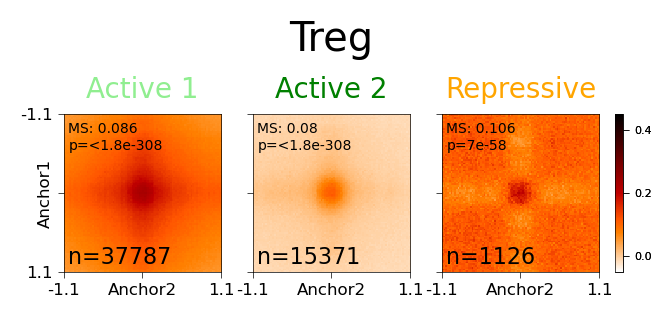

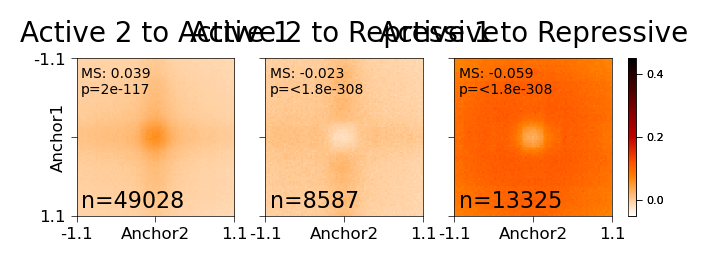

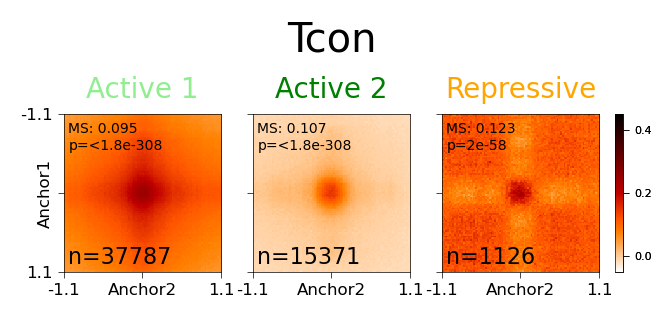

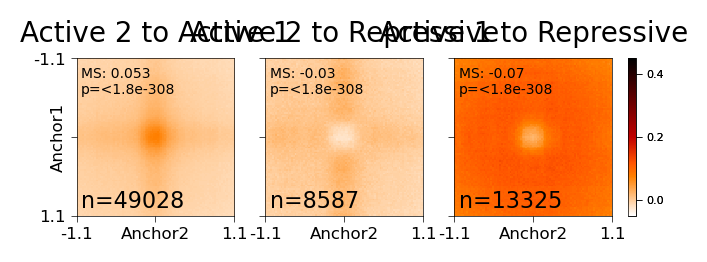

In [34]:
!mkdir -p plots/inter_hub_jesseye_pileup

newline = '\n'
all_results_dicts = {}
for key in inter_hub_all_mat_dict:
    print(key)
    (fig_within_cluster, fig_between_cluster), results = plot_cluster_pileups_from_result(key, inter_hub_all_mat_dict, inter_hub_all_metadata,
                                     inter_hub_all_metadata['cluster1'].unique(),
                                     res = 25_000,
                                     vmax = .45,
                                     vmin = -.05,
                                     columns_to_names = columns_to_names,
                                     row_colors_dict = row_colors_dict,
                                     s1 = 5, s2=None,
                                     center = 5,
                                    )
    fig_within_cluster.suptitle(f"{key}", y=4, x=1.7, ha='center')
    fig_within_cluster.savefig(f'./plots/inter_hub_jesseye_pileup/{key}_within_cluster.pdf', bbox_inches='tight')
    fig_between_cluster.savefig(f'./plots/inter_hub_jesseye_pileup/{key}_between_cluster.pdf', bbox_inches='tight')
    all_results_dicts[key] = results